In [1]:
import math
import numpy as np

from qiskit import QuantumCircuit, transpile

from qiskit_aer import QasmSimulator
from qiskit_aer.noise import NoiseModel, pauli_error

from scipy.optimize import OptimizeResult

In [2]:
# Adam Optimizer

def compute_value_and_grad(x_opt, function, eps):
    f = function(x_opt)
    grad = np.zeros_like(x_opt)

    for i in range(x_opt.size):
        x_plus_h = x_opt.copy()
        x_plus_h[i] += eps
        f_plus_h = function(x_plus_h)
        grad[i] = (f_plus_h - f) / eps
    print("eps: ", eps)
    return f, grad


def adam_optimizer(function, x0, jac=None, iters=100, options=None, beta1=0.9, beta2=0.999, epsilon=1e-8, eps=0.02):
    
    # learning rate
    base_learning_rate = 0.1

    # Adam Variables
    t = 0
    m_t = 0
    v_t = 0

    # Optimization Results
    nit = 0
    nfev = 0
    njev = 0
    success = False
    message = ''
    fun_val = np.inf
    x_opt = np.copy(x0)

    if options is None:
        options = {}
    maxiter = options.get('maxiter', iters)

    while nit < maxiter:
        # compute the function value and gradient
        val, grad = compute_value_and_grad(x_opt, function, eps)
        nfev += 2
        njev += 1

        function_val = val

        # Adam Update
        t += 1
        m_t = beta1*m_t + (1-beta1)*grad
        v_t = beta2*m_t + (1-beta2)*grad**2
        m_t_hat = m_t / (1-beta1**t)
        v_t_hat = v_t / (1-beta2**t)
        current_learning_rate = 0.5*base_learning_rate*( math.cos(math.pi*nit/maxiter) + 1 )
        learning_rate = current_learning_rate / ( np.sqrt(v_t_hat)+epsilon )

        # Update Parameters
        x_opt = x_opt - learning_rate*m_t_hat
        nit += 1
    
    result = OptimizeResult(fun=function_val, x=x_opt, nit=nit, njev=njev, success=success, message=message)
    return result

In [3]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--trial',type= int, default=0)
# parser.add_argument('--shots',type= int)
# args = parser.parse_args()

p_reset = 0.1
p_meas = 0.1
p_gate1 = 0.1
p_phase = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_phase = pauli_error([('Z',p_phase), ('I', 1 - p_phase)])

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1.compose(error_phase), ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2.compose(error_phase.tensor(error_phase)), ["cx"])

In [4]:
# paramters for H2 at R=1.75A
g0 = -0.5597
g1 = +0.1615
g2 = -0.0166
g3 = +0.4148
g4 = +0.1226
g5 = +0.1226
nuclear_repulsion = 0.3023869942
Energy_FCI = -0.97516853

In [9]:
class history:
    def __init__(self):
        self.thetas = []
        self.energies = []
        self.P1 = []
        self.P2 = []
        self.P3 = []

In [12]:

backend = QasmSimulator(method='density_matrix', noise_model=noise_model)

def simulator(theta, shots, history):
    
    print("Shots: ", shots)

    
    # Expectation value of <Z0>, <Z1>, <Z2>
    circuit = QuantumCircuit(2,2)
    circuit.name = 'H2 STO-3G g1-g3'
    circuit.x(0)
    circuit.ry(np.pi/2,1)
    circuit.rx(3*np.pi/2,0)
    circuit.cx(1,0)
    circuit.rz(theta[0],0)
    circuit.cx(1,0)
    circuit.ry(3*np.pi/2,1)
    circuit.rx(np.pi/2,0)
    circuit.measure(range(2), range(2))


    # Run Circuit
    transpiled_circuit = transpile(circuit, backend)
    job = backend.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts(circuit)
    print("Result:", result)
    print("Counts:", counts)
    print("Counts Keys:", counts.items())


    # Probability Distribution
    for k in {'00', '01', '10', '11'}:
        if k not in counts.keys():
            counts[k] = 0 # if k isn't already a key in 'counts', add k to counts with a value of 0
    sorted_counts = sorted(counts.items()) # sort the items (key-value pairs) by key
    print("Sorted Counts:", counts)

    output_distr = [ v[1] / shots for v in sorted_counts ] # normalize
    if (len(output_distr) == 1):
        output_distr.append(1-output_distr[0]) # handle single outcome case
    print("Output Distribution", output_distr)

    E = g0 + nuclear_repulsion
    E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
    E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
    E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    E += E1 + E2 + E3

    print(E)


    
    history.thetas.append(theta)
    history.energies.append(E)

    return E, circuit.draw('mpl', reverse_bits=True)

record_history = history()

E, circ = simulator([4], 200, history=record_history)

Shots:  200
Result: Result(backend_name='qasm_simulator', backend_version='0.14.2', qobj_id='', job_id='b0696a41-36f4-4b22-96e4-d232355b2167', success=True, results=[ExperimentResult(shots=200, success=True, meas_level=2, data=ExperimentResultData(counts={'0x3': 54, '0x1': 35, '0x0': 46, '0x2': 65}), header=QobjExperimentHeader(creg_sizes=[['c', 2]], global_phase=4.71238898038469, memory_slots=2, n_qubits=2, name='H2 STO-3G g1-g3', qreg_sizes=[['q', 2]], metadata={}), status=DONE, seed_simulator=3129078798, metadata={'time_taken': 0.009422091, 'num_bind_params': 1, 'parallel_state_update': 16, 'parallel_shots': 1, 'required_memory_mb': 1, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'density_matrix', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.003979981, 'active_input_qubits': [0, 1], 'num_clbits': 2, 'remapped_qubits': False, 'runtime_parameter_bind': False, 'max_memory_mb': 7640, 'noise': 'superop', 'measure_sampling': True, 'batched_shots_optimization': False, 'fusi

In [90]:
theta_test = [-2]
record_history = history()
shots=2000
result = adam_optimizer (lambda x: simulator(x, shots=shots, history=record_history), theta_test, iters=500, eps=0.02)

Shots:  2000
Result: Result(backend_name='qasm_simulator', backend_version='0.14.2', qobj_id='', job_id='d7fdab19-7b9e-4859-9527-07d08a896e70', success=True, results=[ExperimentResult(shots=2000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x3': 161, '0x1': 1525, '0x0': 280, '0x2': 34}), header=QobjExperimentHeader(creg_sizes=[['c', 2]], global_phase=0.0, memory_slots=2, n_qubits=2, name='H2 STO-3G g1-g3', qreg_sizes=[['q', 2]], metadata={}), status=DONE, seed_simulator=2927144126, metadata={'time_taken': 0.024154395, 'num_bind_params': 1, 'parallel_state_update': 16, 'parallel_shots': 1, 'required_memory_mb': 1, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'density_matrix', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.007064505, 'active_input_qubits': [0, 1], 'num_clbits': 2, 'remapped_qubits': False, 'runtime_parameter_bind': False, 'max_memory_mb': 7640, 'noise': 'superop', 'measure_sampling': True, 'batched_shots_optimization': False, 'fusion': {'

/tmp/ipykernel_2566/3003021617.py:54: RuntimeWarning: invalid value encountered in sqrt
  learning_rate = current_learning_rate / ( np.sqrt(v_t_hat)+epsilon )


Result: Result(backend_name='qasm_simulator', backend_version='0.14.2', qobj_id='', job_id='689836f4-eabc-4b80-8398-e5eb7909b265', success=True, results=[ExperimentResult(shots=2000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 1435, '0x2': 40, '0x0': 350, '0x3': 175}), header=QobjExperimentHeader(creg_sizes=[['c', 2]], global_phase=0.0, memory_slots=2, n_qubits=2, name='H2 STO-3G g1-g3', qreg_sizes=[['q', 2]], metadata={}), status=DONE, seed_simulator=1145724859, metadata={'time_taken': 0.002636726, 'num_bind_params': 1, 'parallel_state_update': 16, 'parallel_shots': 1, 'required_memory_mb': 1, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'density_matrix', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.000522814, 'active_input_qubits': [0, 1], 'num_clbits': 2, 'remapped_qubits': False, 'runtime_parameter_bind': False, 'max_memory_mb': 7640, 'noise': 'superop', 'measure_sampling': True, 'batched_shots_optimization': False, 'fusion': {'applied': Fal

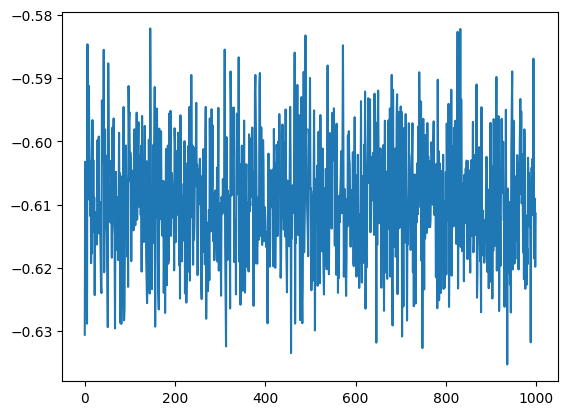

In [94]:
import matplotlib.pyplot as plt
plt.plot(record_history.energies)

[0.2, 0.02, 0.1, 0.0]


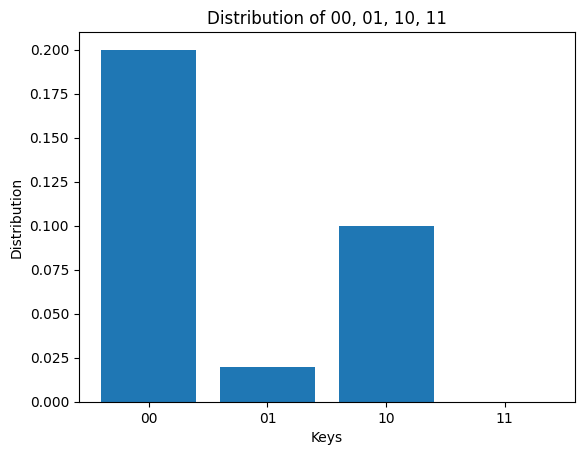

In [69]:
import matplotlib.pyplot as plt

# Example data
counts = {'00': 10, '01': 1, '10': 5}  # Example counts
shots = 50  # Total number of shots

# Ensure all possible keys are in the counts dictionary
for k in {'00', '01', '10', '11'}:
    if k not in counts.keys():
        counts[k] = 0

# Sort the counts by key
sorted_counts = sorted(counts.items())

# Calculate the distribution
output_distr = [v[1] / shots for v in sorted_counts]

# Ensure the distribution sums to 1 if there is only one key
if len(output_distr) == 1:
    output_distr.append(1 - output_distr[0])

# Print the distribution
print(output_distr)

# Plotting the bar chart
keys = [k for k, v in sorted_counts]
values = output_distr

plt.bar(keys, values)
plt.xlabel('Keys')
plt.ylabel('Distribution')
plt.title('Distribution of 00, 01, 10, 11')
plt.show()


In [25]:
def apply_simulation(func, data):
    results = []
    for item in data:
        results.append(func(item))
    return results

data = [1,2,3,4]
per_shots = 1000
record_history = True

simulation_results = apply_simulation(lambda x: simulator(x), data)

TypeError: 'int' object is not subscriptable

#### Single Measurement Tests

Shots:  600
Original Circuit:


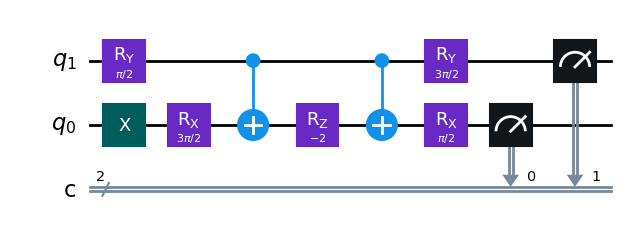

In [18]:
shots = 600
theta = [-2]
backend = QasmSimulator(method='density_matrix', noise_model=noise_model)


print("Shots: ", shots)


# Expectation value of <Z0>, <Z1>, <Z2>
circuit = QuantumCircuit(2,2)
circuit.name = 'H2 STO-3G g1-g3'
circuit.x(0)
circuit.ry(np.pi/2,1)
circuit.rx(3*np.pi/2,0)
circuit.cx(1,0)
circuit.rz(theta[0],0)
circuit.cx(1,0)
circuit.ry(3*np.pi/2,1)
circuit.rx(np.pi/2,0)
circuit.measure(range(2), range(2))

print("Original Circuit:")
circuit.draw()

Transpiled Circuit:


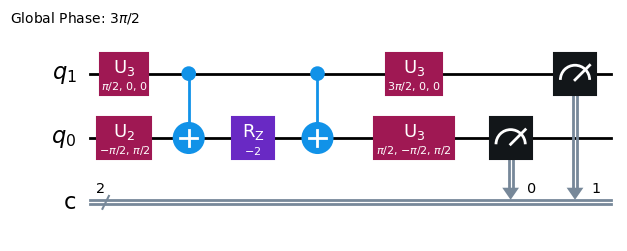

In [20]:
# Run Circuit
transpiled_circuit = transpile(circuit, backend)
print("Transpiled Circuit:")
transpiled_circuit.draw()

In [22]:
job = backend.run(transpiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts(circuit)
print("Result:", result)
print("Counts:", counts)
print("Counts Keys:", counts.items())


# Probability Distribution
for k in {'00', '01', '10', '11'}:
    if k not in counts.keys():
        counts[k] = 0 # if k isn't already a key in 'counts', add k to counts with a value of 0
sorted_counts = sorted(counts.items()) # sort the items (key-value pairs) by key
print("Sorted Counts:", counts)

output_distr = [ v[1] / shots for v in sorted_counts ] # normalize
if (len(output_distr) == 1):
    output_distr.append(1-output_distr[0]) # handle single outcome case
print("Output Distribution", output_distr)

E = g0 + nuclear_repulsion
E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
E += E1 + E2 + E3

print(E)



# history.thetas.append(theta)
# history.energies.append(E)


# record_history = history()


Result: Result(backend_name='qasm_simulator', backend_version='0.14.2', qobj_id='', job_id='325ca6ff-cda5-424b-99ce-03d419690b0e', success=True, results=[ExperimentResult(shots=600, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 131, '0x3': 145, '0x0': 147, '0x2': 177}), header=QobjExperimentHeader(creg_sizes=[['c', 2]], global_phase=4.71238898038469, memory_slots=2, n_qubits=2, name='H2 STO-3G g1-g3', qreg_sizes=[['q', 2]], metadata={}), status=DONE, seed_simulator=716650670, metadata={'time_taken': 0.012069631, 'num_bind_params': 1, 'parallel_state_update': 16, 'parallel_shots': 1, 'required_memory_mb': 1, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'density_matrix', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.003959127, 'active_input_qubits': [0, 1], 'num_clbits': 2, 'remapped_qubits': False, 'runtime_parameter_bind': False, 'max_memory_mb': 7640, 'noise': 'superop', 'measure_sampling': True, 'batched_shots_optimization': False, 'fusion': {'ap

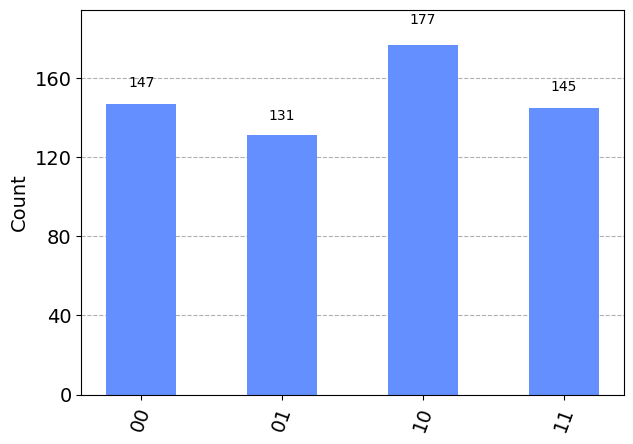

In [26]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)